### https://github.com/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb

In [1]:
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
%matplotlib inline

In [3]:
from lutils.stock import LTdxHq

In [4]:
ltdxhq = LTdxHq()

In [5]:
code = '000001'

In [6]:
df = ltdxhq.get_k_data_daily(code, start='2001-01-01')

In [7]:
df

,open,close,high,low,volume,amount
date,,,,,,
2001-01-02,3.42,3.43,3.46,3.39,3412200.0,4.950500e+07
2001-01-03,3.43,3.40,3.44,3.38,5429400.0,7.830400e+07
2001-01-04,3.40,3.38,3.42,3.37,4840400.0,6.957300e+07
2001-01-05,3.38,3.34,3.38,3.33,6641900.0,9.415400e+07
2001-01-08,3.34,3.30,3.34,3.29,6994400.0,9.804400e+07
...,...,...,...,...,...,...
2022-12-09,13.40,13.70,13.75,13.35,161583200.0,2.197502e+09
2022-12-12,13.58,13.11,13.58,13.06,139258432.0,1.848278e+09
2022-12-13,13.15,13.24,13.36,13.14,90228512.0,1.194285e+09


In [8]:
config = {
#     "alpha_vantage": {
#         "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
#         "symbol": "IBM",
#         "outputsize": "full",
#         "key_adjusted_close": "5. adjusted close",
#     },
    'symbol': '000001',
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 400,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [9]:
num_data_points = df.shape[0]

In [10]:
data_close_price = df.close.to_numpy()

In [11]:
data_date = df.index.strftime('%Y-%m-%d').to_list()
# data_date.reverse()

In [12]:
display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]

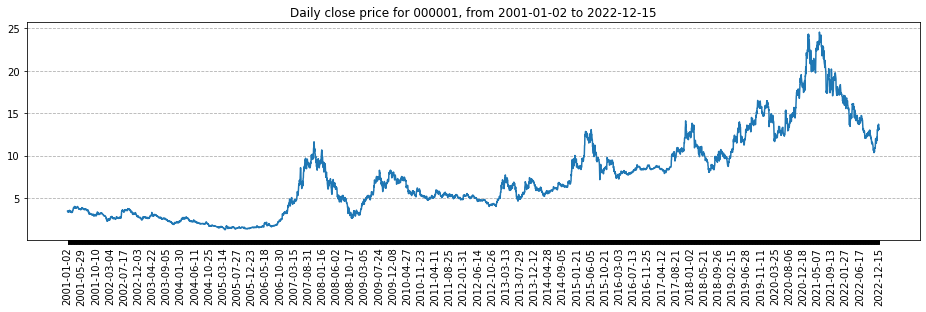

In [13]:
fig = plt.figure(figsize = (16, 4))
plt.plot(data_date, df.close)
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')

In [14]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(df.close.to_numpy())

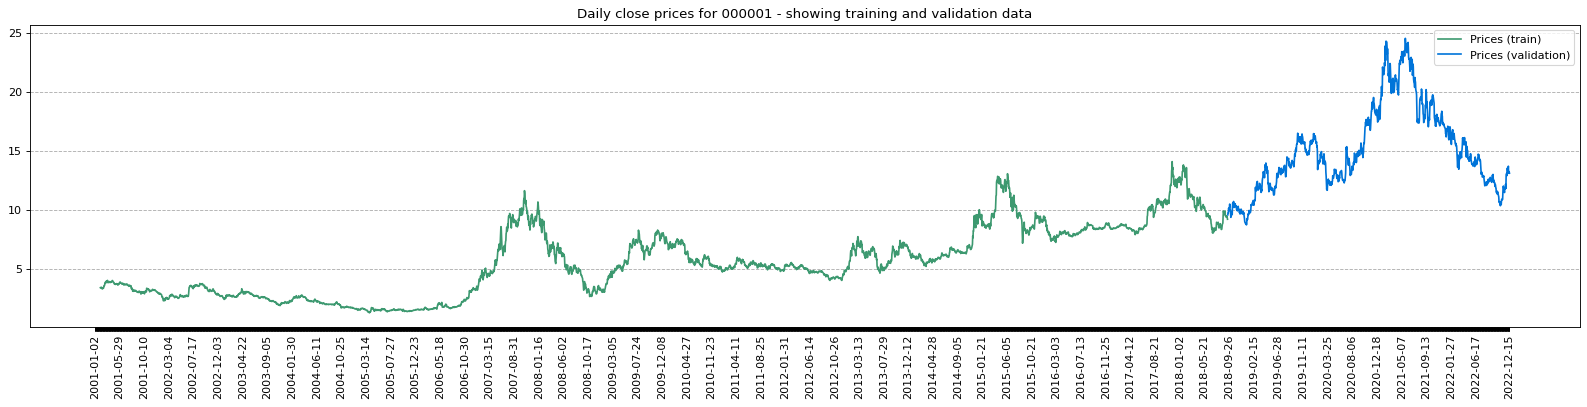

In [15]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=True)

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4115, 20, 1) (4115,)
Validation data shape (1029, 20, 1) (1029,)


In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [18]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/400] | loss train:0.029091, test:0.101969 | lr:0.010000
Epoch[2/400] | loss train:0.005591, test:0.144605 | lr:0.010000
Epoch[3/400] | loss train:0.005800, test:0.074438 | lr:0.010000
Epoch[4/400] | loss train:0.004701, test:0.052886 | lr:0.010000
Epoch[5/400] | loss train:0.003888, test:0.100114 | lr:0.010000
Epoch[6/400] | loss train:0.004257, test:0.101302 | lr:0.010000
Epoch[7/400] | loss train:0.003592, test:0.041257 | lr:0.010000
Epoch[8/400] | loss train:0.003471, test:0.042569 | lr:0.010000
Epoch[9/400] | loss train:0.003877, test:0.133002 | lr:0.010000
Epoch[10/400] | loss train:0.003909, test:0.152521 | lr:0.010000
Epoch[11/400] | loss train:0.003760, test:0.123157 | lr:0.010000
Epoch[12/400] | loss train:0.003900, test:0.094880 | lr:0.010000
Epoch[13/400] | loss train:0.003204, test:0.025216 | lr:0.010000
Epoch[14/400] | loss train:0.003778, test:0.096092 | lr:0.010000
Epoch[15/400] | loss train:0.003245, test:0.044462 | lr:0.010000
Epoch[16/400] | loss train:0.00366

Epoch[126/400] | loss train:0.002398, test:0.036154 | lr:0.000010
Epoch[127/400] | loss train:0.002558, test:0.031708 | lr:0.000010
Epoch[128/400] | loss train:0.002483, test:0.047632 | lr:0.000010
Epoch[129/400] | loss train:0.002495, test:0.026021 | lr:0.000010
Epoch[130/400] | loss train:0.002512, test:0.063626 | lr:0.000010
Epoch[131/400] | loss train:0.002457, test:0.057662 | lr:0.000010
Epoch[132/400] | loss train:0.002636, test:0.066013 | lr:0.000010
Epoch[133/400] | loss train:0.002521, test:0.031137 | lr:0.000010
Epoch[134/400] | loss train:0.002457, test:0.062527 | lr:0.000010
Epoch[135/400] | loss train:0.002442, test:0.028715 | lr:0.000010
Epoch[136/400] | loss train:0.002495, test:0.030086 | lr:0.000010
Epoch[137/400] | loss train:0.002615, test:0.068366 | lr:0.000010
Epoch[138/400] | loss train:0.002380, test:0.032311 | lr:0.000010
Epoch[139/400] | loss train:0.002364, test:0.065627 | lr:0.000010
Epoch[140/400] | loss train:0.002478, test:0.038653 | lr:0.000010
Epoch[141/

Epoch[250/400] | loss train:0.002425, test:0.046307 | lr:0.000000
Epoch[251/400] | loss train:0.002553, test:0.034806 | lr:0.000000
Epoch[252/400] | loss train:0.002503, test:0.053014 | lr:0.000000
Epoch[253/400] | loss train:0.002407, test:0.068224 | lr:0.000000
Epoch[254/400] | loss train:0.002427, test:0.030427 | lr:0.000000
Epoch[255/400] | loss train:0.002461, test:0.048873 | lr:0.000000
Epoch[256/400] | loss train:0.002495, test:0.028528 | lr:0.000000
Epoch[257/400] | loss train:0.002448, test:0.045899 | lr:0.000000
Epoch[258/400] | loss train:0.002522, test:0.026379 | lr:0.000000
Epoch[259/400] | loss train:0.002628, test:0.026650 | lr:0.000000
Epoch[260/400] | loss train:0.002475, test:0.029731 | lr:0.000000
Epoch[261/400] | loss train:0.002521, test:0.034013 | lr:0.000000
Epoch[262/400] | loss train:0.002477, test:0.025674 | lr:0.000000
Epoch[263/400] | loss train:0.002486, test:0.036664 | lr:0.000000
Epoch[264/400] | loss train:0.002509, test:0.035733 | lr:0.000000
Epoch[265/

Epoch[375/400] | loss train:0.002431, test:0.038402 | lr:0.000000
Epoch[376/400] | loss train:0.002479, test:0.030202 | lr:0.000000
Epoch[377/400] | loss train:0.002302, test:0.044178 | lr:0.000000
Epoch[378/400] | loss train:0.002577, test:0.032196 | lr:0.000000
Epoch[379/400] | loss train:0.002603, test:0.050624 | lr:0.000000
Epoch[380/400] | loss train:0.002424, test:0.054756 | lr:0.000000
Epoch[381/400] | loss train:0.002508, test:0.074619 | lr:0.000000
Epoch[382/400] | loss train:0.002578, test:0.029325 | lr:0.000000
Epoch[383/400] | loss train:0.002541, test:0.045837 | lr:0.000000
Epoch[384/400] | loss train:0.002418, test:0.024927 | lr:0.000000
Epoch[385/400] | loss train:0.002504, test:0.029805 | lr:0.000000
Epoch[386/400] | loss train:0.002642, test:0.052307 | lr:0.000000
Epoch[387/400] | loss train:0.002609, test:0.054774 | lr:0.000000
Epoch[388/400] | loss train:0.002474, test:0.038002 | lr:0.000000
Epoch[389/400] | loss train:0.002384, test:0.029203 | lr:0.000000
Epoch[390/

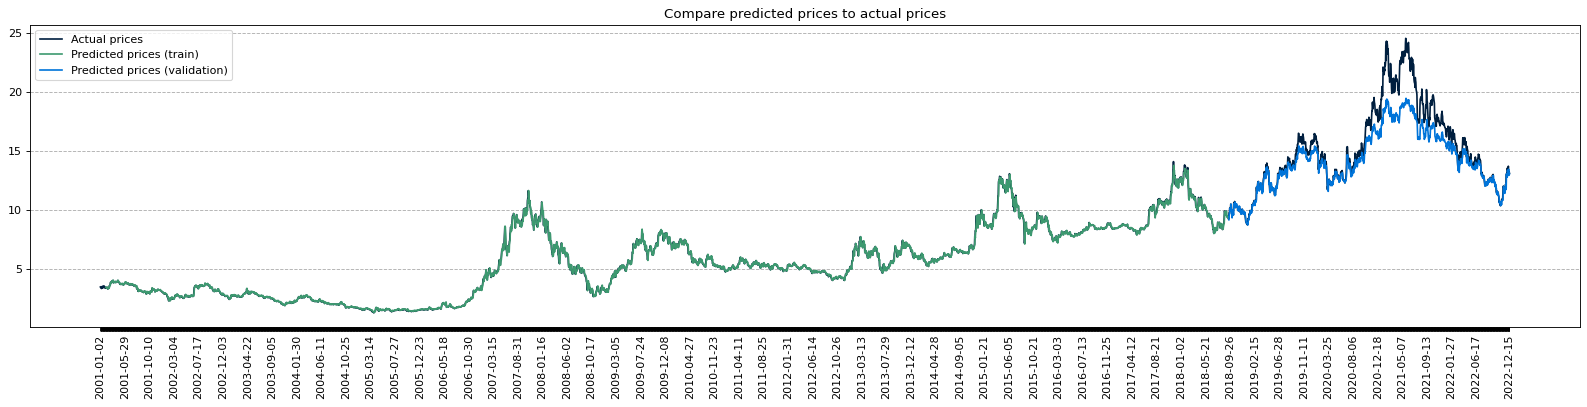

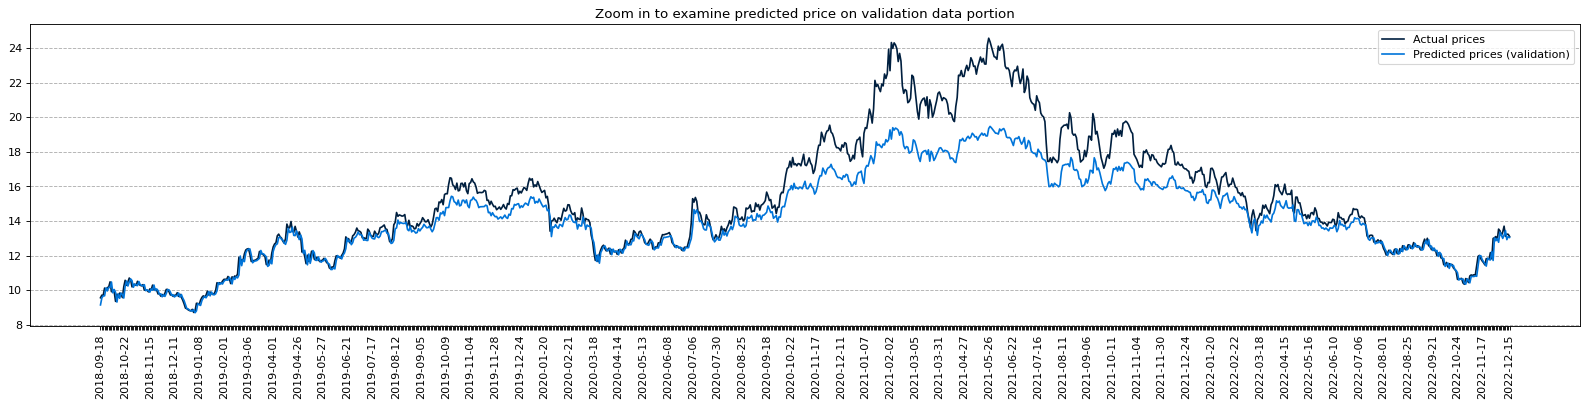

In [19]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

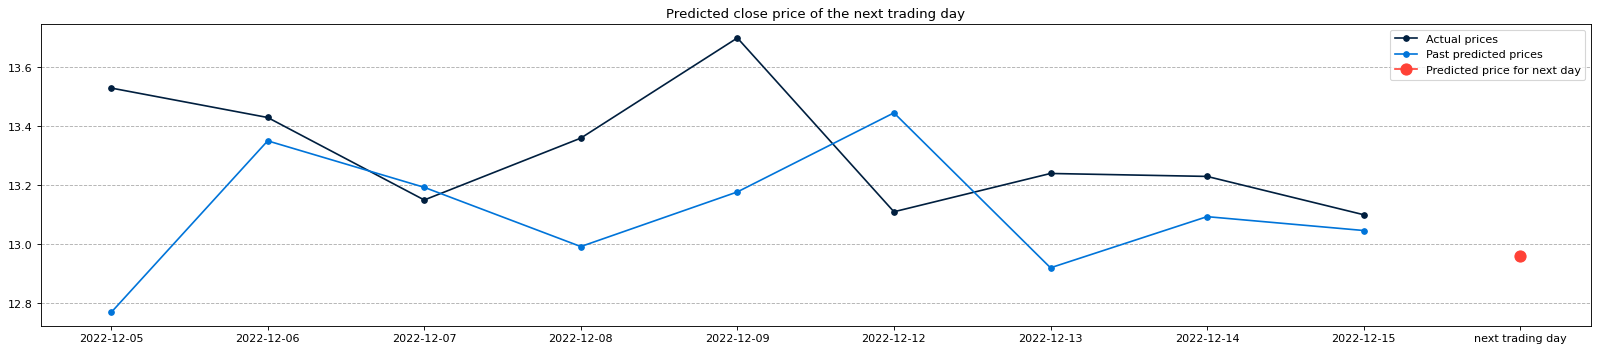

Predicted close price of the next trading day: 12.96


In [20]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))